# Statistical Methods for Machine Learning project

In [20]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

import math

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [21]:
if 'google.colab' in str(get_ipython()):
    COLAB = True
else:
    COLAB = False

In [22]:
import kagglehub
import shutil

# Download latest version
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'rockpaperscissors' dataset.
Path to dataset files: /kaggle/input/rockpaperscissors


(200, 300, 3)


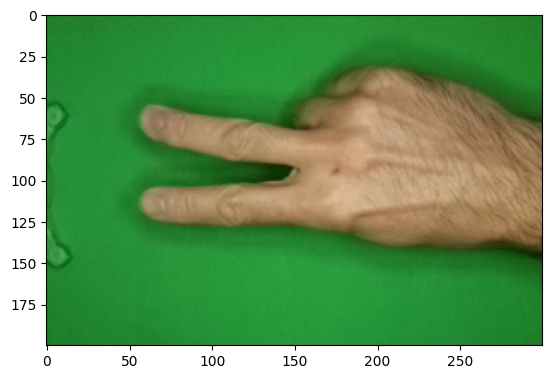

In [23]:
plt.figure()
folder = os.path.join(path, random.choice(['rock','paper','scissors']))
img_name = random.choice(os.listdir(folder))
img = io.imread(os.path.join(folder,img_name))
print( img.shape)
plt.imshow(img)
plt.show()

# Creation of training and validation folders

In [24]:
# creation of training and validation folders
ratio = 0.8
subfolders = ['rock','paper','scissors']

os.makedirs('train', exist_ok=True)
os.makedirs('val', exist_ok=True)
for subfolder in subfolders:
    subpath = os.path.join(path, subfolder)
    os.makedirs(os.path.join('train',subfolder))
    os.makedirs(os.path.join('val',subfolder))

    imgs = os.listdir(subpath)
    random.shuffle(imgs)

    train_size = int(0.8 * len(imgs))
    val_size = len(imgs) - train_size

    train_imgs = imgs[:train_size]
    val_imgs = imgs[train_size:]

    for i in train_imgs:
        shutil.copy(os.path.join(subpath,i), os.path.join('train',subfolder,i))
    for i in val_imgs:
        shutil.copy(os.path.join(subpath,i), os.path.join('val',subfolder,i))




FileExistsError: [Errno 17] File exists: 'train/rock'

# Transformation and data augmentation

In [25]:
# no need to resize since all images have the same dimension (?)
# validation set only transformed to tensor
# training set augmented with random transformations

val_transform = transforms.Compose([
    transforms.ToTensor()
])
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(-20,20)),
])

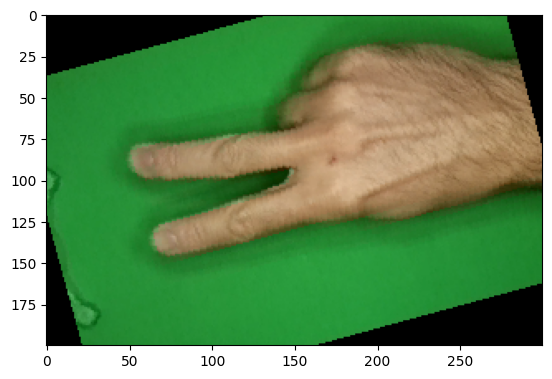

In [26]:
transformed_img = train_transform(img)
plt.imshow(transformed_img.permute(1,2,0))
plt.show()

# DataLoader creation

In [27]:
batch_size = 9
train_dataset = datasets.ImageFolder(root='train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='val', transform=val_transform)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size)

classes = train_dataset.classes

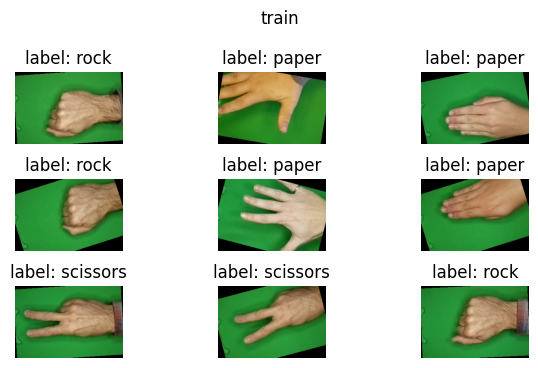

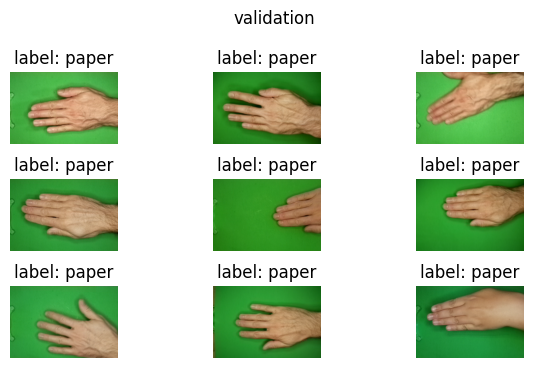

In [28]:
def show_batch(x, y, yh=None, title=None):
    col = math.floor(math.sqrt(len(x)))
    row = col+1
    for i in range(len(x)):
        ax = plt.subplot(row,col,i+1)
        plt.tight_layout()
        subtitle = 'label: ' + classes[int(y[i])]
        if (yh is not None):
            subtitle += '\nprediction: ' + classes[int(np.argmax(yh[i]))]
        ax.set_title(subtitle)
        ax.axis('off')
        plt.imshow(x[i].permute(1,2,0))
    if (title):
        plt.subplots_adjust(top=0.85)
        plt.suptitle(title)
    plt.show()

show_batch(*next(iter(train_dl)), title='train')
show_batch(*next(iter(val_dl)), title='validation')

# SomeNet

In [29]:
class SomeNet(nn.Module):
    def __init__(self):
        super().__init__()
        #2D convolution with 3 input channels, 16 output channels, and 5x5 filters
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.norm1 = nn.BatchNorm2d(6)

        self.conv2 = nn.Conv2d(6,16,3)
        self.middleconv2 = nn.Conv2d(16,16,3)
        self.norm2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16,64,3)
        self.norm3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64,120,3)
        self.middleconv4 = nn.Conv2d(120,120,3)
        self.norm4 = nn.BatchNorm2d(120)

        self.fc1 = nn.Linear(162*10*10,120)
        self.fc2 = nn.Linear(120,64)
        self.fc3 = nn.Linear(64,3)

    def forward(self, x):
        x = self.pool(F.relu(self.norm1(self.conv1(x))))
        x = F.relu(self.norm2(self.conv2(x)))
        x = self.pool(F.relu(self.norm2(self.middleconv2(x))))
        x = self.pool(F.relu(self.norm3(self.conv3(x))))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.middleconv4(x)))

        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [30]:
net = SomeNet()
net.to(device)

img,lbl=next(iter(train_dl))
inputs = img.to(device).float()
labels = lbl.to(device).float()

print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

#Lo pasamos por la red
with torch.set_grad_enabled(False):
    outputs = net(inputs)
    print('Size of the output tensor is {}'.format(outputs.shape))

Size of tensor containing a batch of images is torch.Size([9, 3, 200, 300])
Size of the output tensor is torch.Size([9, 3])


In [31]:
#train_model parameters are the network (model), the criterion (loss),
# the optimizer, a learning scheduler (una estrategia de lr strategy), and the training epochs
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    classes = dataloaders['train'].dataset.classes
    numClasses = len(classes)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_auc = 1000000
    best_aucs = np.array([best_auc, best_auc])

    train_loss_time = []
    val_loss_time = []

    best_epoch = -1

    #Loop of epochs (each iteration involves train and val datasets)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)



        # Cada época tiene entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in val mode (no grads)


            #Dataset size
            numSamples = dataset_sizes[phase]

            # Create variables to store outputs and labels
            outputs_m=np.zeros((numSamples,numClasses),dtype=float)
            labels_m=np.zeros((numSamples,),dtype=int)
            running_loss = 0.0

            contSamples=0

            # Iterate (loop of batches)
            for img,lbl in dataloaders[phase]:
                inputs = img.to(device).float()
                labels = lbl.to(device)


                # Set grads to zero
                optimizer.zero_grad()

                # Forward
                # Register ops only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward & parameters update only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Accumulate the running loss
                running_loss += loss.item() * inputs.size(0)

                #Apply a softmax to the output
                outputs=F.softmax(outputs.data,dim=1)
                # Store outputs and labels
                outputs_m [contSamples:contSamples+batch_size,...]=outputs.cpu().numpy()
                labels_m [contSamples:contSamples+batch_size]=labels.cpu().numpy()
                contSamples+=batch_size

            #At the end of an epoch, update the lr scheduler
            if phase == 'train':
                scheduler.step()

            #Accumulated loss by epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == 'train':
                train_loss_time.append(epoch_loss)
            else:
                val_loss_time.append(epoch_loss)

            #Compute the AUCs at the end of the epoch
            aucs=np.array([epoch_loss,epoch_loss])#computeAUCs(outputs_m,labels_m)

            #And the Average AUC
            epoch_auc = aucs.mean()

            print('{} Loss: {:.4f} AUC mel: {:.4f} sk: {:.4f} avg: {:.4f}'.format(
                phase, epoch_loss, aucs[0], aucs[1], epoch_auc))

            # Deep copy of the best model
            if phase == 'val' and epoch_auc < best_auc:
                best_auc = epoch_auc
                best_aucs = aucs.copy()
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best model in epoch {:d} val AUCs: mel {:4f} sk {:4f} avg {:4f}'.format(best_epoch,best_aucs[0],best_aucs[1],best_auc))

    plt.plot(train_loss_time, 'bo-', label='train loss')
    plt.plot(val_loss_time, 'r+-', label='val loss')
    plt.show()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(net.parameters(), lr=1e-3)
# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


image_datasets = {'train' : train_dataset, 'val': val_dataset}

dls = {'train' : train_dl, 'val': val_dl}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
net = train_model(net, dls, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.4697 AUC mel: 0.4697 sk: 0.4697 avg: 0.4697
val Loss: 0.6884 AUC mel: 0.6884 sk: 0.6884 avg: 0.6884

Epoch 1/19
----------
train Loss: 0.1375 AUC mel: 0.1375 sk: 0.1375 avg: 0.1375
val Loss: 0.2522 AUC mel: 0.2522 sk: 0.2522 avg: 0.2522

Epoch 2/19
----------
train Loss: 0.1148 AUC mel: 0.1148 sk: 0.1148 avg: 0.1148
val Loss: 1.4180 AUC mel: 1.4180 sk: 1.4180 avg: 1.4180

Epoch 3/19
----------


KeyboardInterrupt: 

Size of tensor containing a batch of images is torch.Size([9, 3, 200, 300])


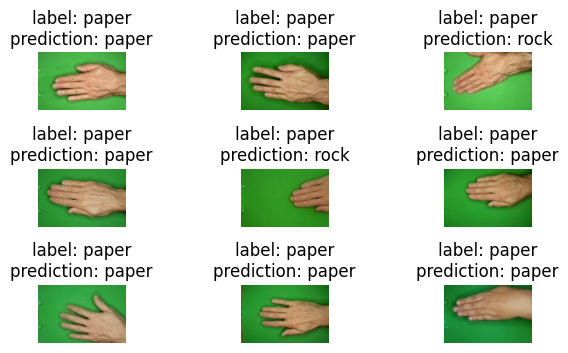

In [33]:
img,lbl=next(iter(val_dl))
inputs = img.to(device).float()
labels = lbl.to(device).float()

print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

#Lo pasamos por la red
with torch.set_grad_enabled(False):
    outputs = net(inputs)




if (device=='cpu'):
    show_batch(img,lbl,outputs)
else:
    show_batch(img,lbl,outputs.cpu().numpy())



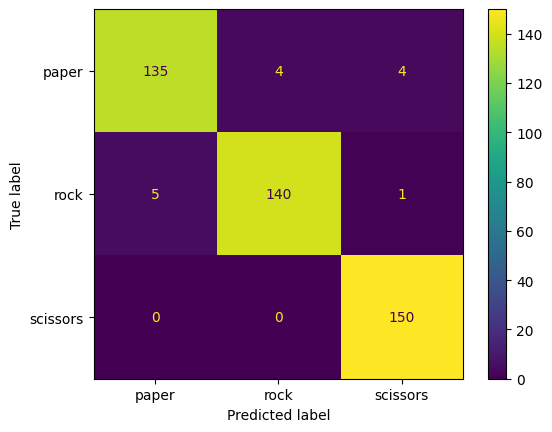

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y = []
y_hat = []

with torch.set_grad_enabled(False):
    for img, lbls in val_dl:
        output = net(img.to(device).float()).to('cpu').float()
        y.extend(lbls)
        pred = output.data.max(1, keepdim=True)[1]
        y_hat.extend(pred)

cm = confusion_matrix(y, y_hat, labels=range(len(classes)))
ConfusionMatrixDisplay(cm,display_labels=classes).plot()

In [35]:
print(classes)

['paper', 'rock', 'scissors']


In [36]:
!pip install torchmetrics

In [41]:
from tqdm import tqdm
import torchmetrics
from torchmetrics import Accuracy, Precision, Recall

def train_model(model, dataloaders,  criterion, optimizer, scheduler, num_epochs=25):
    stats = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': [],
            'val_rec': [],
            'val_prec': []
    }
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)

        # TRAIN
        running_loss = 0
        for batch_index, (images, labels) in enumerate(tqdm(dataloaders['train'])):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            running_loss += loss.item()*images.size(0)
            optimizer.step()

        epoch_loss = running_loss / len(dataloaders['train'])
        stats['train_loss'].append(epoch_loss)
        # VAL
        # Set up of multiclass accuracy metric
        acc = Accuracy(task="multiclass",num_classes=len(classes)).to(device)
        precision = Precision(task="multiclass", num_classes=len(classes), average='macro').to(device)
        recall = Recall(task="multiclass", num_classes=len(classes), average='macro').to(device)

        # Iterate over the dataset batches
        model.eval()
        with torch.no_grad():
            for images, labels in dataloaders['val']: # Changed 'test' to 'val' based on existing dataloaders
                images = images.to(device)
                labels = labels.to(device)
                # Get predicted probabilities for test data batch
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()*images.size(0)
                _, preds = torch.max(outputs, 1)
                acc(preds, labels)
                precision(preds, labels)
                recall(preds, labels)

            val_loss = running_loss / len(dataloaders['val'])
            test_accuracy = acc.compute()
            test_precision = precision.compute()
            test_recall = recall.compute()

            stats['val_loss'].append(val_loss)
            stats['val_acc'].append(test_accuracy)
            stats['val_rec'].append(test_recall)
            stats['val_prec'].append(test_precision)


        print(f"Train loss: {epoch_loss:.4f}")
        print(f"Test loss: {val_loss:.4f}")
        print(f"Test accuracy: {test_accuracy:.4f}")
        print(f"Test precision: {test_precision:.4f}")
        print(f"Test recall: {test_recall:.4f}")

    plt.plot(stats['train_loss'], 'bo-', label='train loss')
    plt.plot(stats['val_loss'], 'r+-', label='val loss')
    plt.show()

    plt.plot(stats['val_acc'])
    plt.plot(stats['val_rec'])
    plt.plot(stats['val_prec'])
    plt.show()

Epoch 0/3
----------


100%|██████████| 195/195 [01:08<00:00,  2.84it/s]


Train loss: 0.7158
Test loss: 3.6384
Test accuracy: 0.9749
Test precision: 0.9755
Test recall: 0.9753
Epoch 1/3
----------


100%|██████████| 195/195 [01:09<00:00,  2.82it/s]


Train loss: 0.3671
Test loss: 1.8310
Test accuracy: 0.9841
Test precision: 0.9840
Test recall: 0.9840
Epoch 2/3
----------


100%|██████████| 195/195 [01:10<00:00,  2.77it/s]


Train loss: 0.1777
Test loss: 2.2996
Test accuracy: 0.9613
Test precision: 0.9633
Test recall: 0.9605
Epoch 3/3
----------


100%|██████████| 195/195 [01:10<00:00,  2.77it/s]


Train loss: 0.3417
Test loss: 1.8682
Test accuracy: 0.9863
Test precision: 0.9863
Test recall: 0.9862


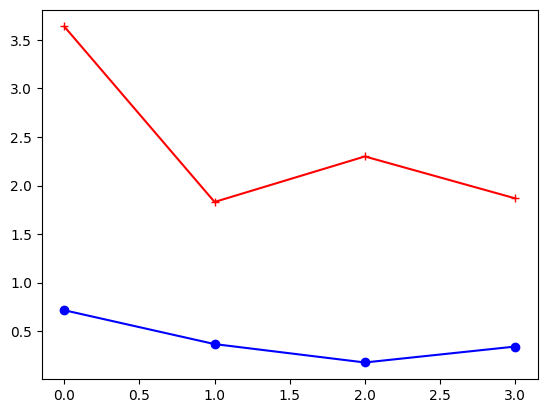

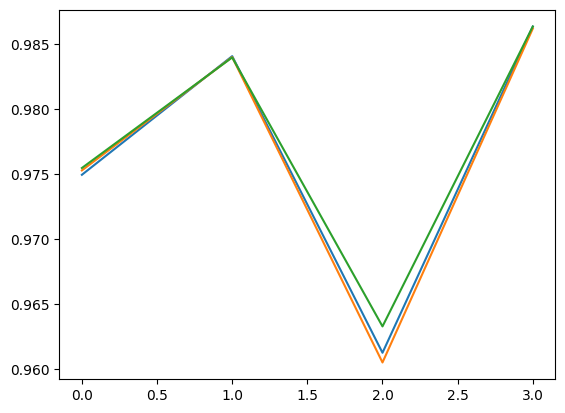

In [42]:
train_model(net, dls, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=4)